# Analyze visually evoked responses (ERPs) 

## Set-up

#### Imports

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [7]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import odml
from scipy.signal import find_peaks, peak_widths

# custom
import sys
sys.path.append("../../code")
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS, EPOCH_TIMES, N_CHANS, N_ARRAYS, STIM_DURATION
from plots import plot_schematic, plot_erp, plot_event_traces
from utils import compute_erp, trim_signal, comp_erp_params

#### Settings

In [4]:
# global variables
T_BASELINE = (-0.3, 0) # baseline period for ERP calculation (s)

In [5]:
# init time-vector
time = np.arange(EPOCH_TIMES[0], EPOCH_TIMES[1], 1/FS)

#### Functions

## Main

#### Create output directory

In [8]:
dir_out = f"{PROJECT_PATH}/figures/erp"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [10]:
# load example LFP epochs
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_epochs/{SESSIONS[0]}"
fname_in = fr"{dir_input}\NSP1_array1_LFP.npy"
lfp = np.load(fname_in)

print(f"LFP Shape: \t{lfp.shape} (trials x channels x samples)")

LFP Shape: 	(170, 64, 500) (trials x channels x samples)


In [14]:
# load metadata for example sessions
odml_path = fr"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{SESSIONS[0]}/metadata_{SESSIONS[0]}.odml"
metadata = odml.load(odml_path)

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.


### Compute ERP

In [15]:
# compute ERP - subtract baseline, average over trials
erp = compute_erp(lfp, time, t_baseline=T_BASELINE)
print(f"ERP Shape: \t{erp.shape} (channels x samples)")

ERP Shape: 	(64, 500) (channels x samples)


### Plot ERP

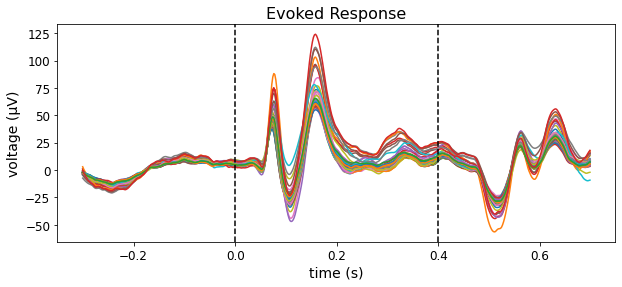

In [16]:
# plot example erp
fig, ax = plt.subplots(figsize=(10, 4))
plot_erp(erp, time, ax=ax, annotate_times=[0,0.4])

In [17]:
# plot ERP plot for each array in session, for all sessions

for session in SESSIONS:
    print(f"\nPlotting session: {session}")
    # define input/output path
    dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_epochs/{session}"
    dir_fig = f"{dir_out}/{session}"
    if not os.path.exists(dir_fig):
        os.makedirs(dir_fig)

    # loop through arrays
    for i_array in range(1, N_ARRAYS+1):
        print(f"    plotting array: {i_array}/{N_ARRAYS}")
        idx_nsp = (i_array+1) // 2

        # load data
        fname_in = f"NSP{idx_nsp}_array{i_array}_LFP.npy"
        lfp = np.load(f"{dir_input}/{fname_in}")

        # compute erp
        erp = compute_erp(lfp, time, t_baseline=T_BASELINE)

        # plot
        fig, ax = plt.subplots(figsize=(10, 4))
        plot_erp(erp, time, ax=ax, annotate_times=[0,0.4])
        ax.set_title(f"{session} - {fname_in.replace('_LFP.npy','')}")

        # save and close
        fig.savefig(f"{dir_fig}/{fname_in.replace('.npy','.png')}")
        plt.close('all')
            




Plotting session: A_SNR_140819
    plotting array: 1/16
    plotting array: 2/16
    plotting array: 3/16
    plotting array: 4/16
    plotting array: 5/16
    plotting array: 6/16
    plotting array: 7/16
    plotting array: 8/16
    plotting array: 9/16
    plotting array: 10/16
    plotting array: 11/16
    plotting array: 12/16
    plotting array: 13/16
    plotting array: 14/16
    plotting array: 15/16
    plotting array: 16/16

Plotting session: L_SNR_250717
    plotting array: 1/16
    plotting array: 2/16
    plotting array: 3/16
    plotting array: 4/16
    plotting array: 5/16
    plotting array: 6/16
    plotting array: 7/16
    plotting array: 8/16
    plotting array: 9/16
    plotting array: 10/16
    plotting array: 11/16
    plotting array: 12/16
    plotting array: 13/16
    plotting array: 14/16
    plotting array: 15/16
    plotting array: 16/16


#### plot mean ERP for each array in a session


(16, 500)


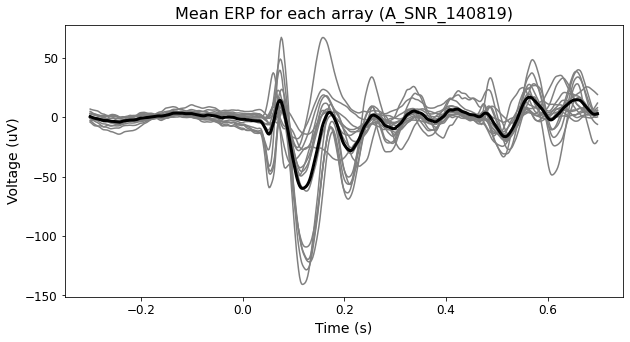

In [26]:
# plotting the mean for each array in a session
dir_input = fr"{EXTERNAL_PATH}\data\lfp\lfp_epochs\{SESSIONS[0]}"

# create empty array for erp mean
erps = np.zeros([N_ARRAYS, N_CHANS, int(np.diff(EPOCH_TIMES)*FS)])

# loop through arrays
for ii in range(N_ARRAYS):
    idx_array = ii + 1
    idx_nsp = (idx_array+1) // 2

    # load data and compute erp
    fname_in = fr"{dir_input}\NSP{idx_nsp}_array{idx_array}_LFP.npy"
    lfp = np.load(fname_in)
    erps[ii] = compute_erp(lfp, time, t_baseline=T_BASELINE)

# compute mean of all arrays
erp_array = np.nanmean(erps, axis=1)
print(erp_array.shape)

# plot mean of all arrays
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, erp_array.T, color='grey')
ax.plot(time, np.nanmean(erp_array, axis=0), color='k', linewidth=3)
ax.set_title(f"Mean ERP for each array ({SESSIONS[0]})")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (uV)")
plt.show()

Plotting session: A_SNR_140819
Plotting session: L_SNR_250717


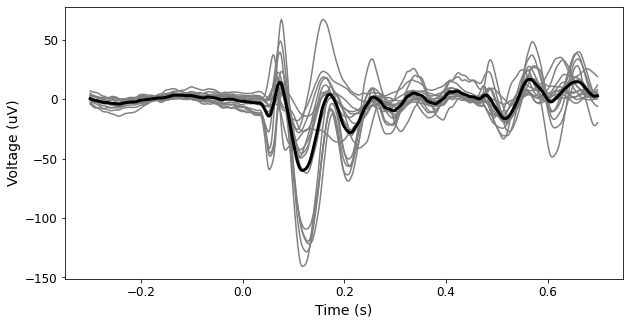

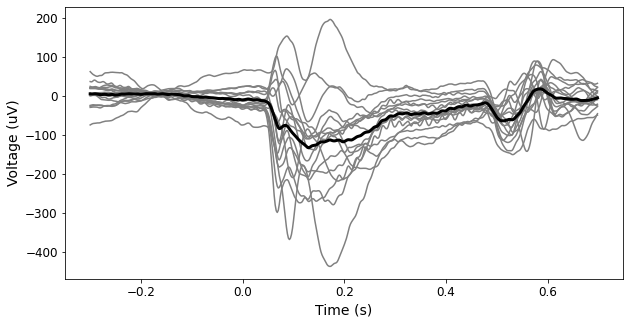

In [28]:
# repeat for all sessions
for session in SESSIONS:
    print(f"Plotting session: {session}")

    # define input/output path
    dir_input = fr"{EXTERNAL_PATH}\data\lfp\lfp_epochs\{session}"
    dir_fig = f"{dir_out}/{session}"
    if not os.path.exists(dir_fig):
        os.makedirs(dir_fig)

    # create empty array for erp mean
    erps = np.zeros([N_ARRAYS, N_CHANS, int(np.diff(EPOCH_TIMES)*FS)])

    # loop through arrays
    for ii in range(N_ARRAYS):
        idx_array = ii + 1
        idx_nsp = (idx_array+1) // 2

        # load data and compute erp
        fname_in = fr"{dir_input}\NSP{idx_nsp}_array{idx_array}_LFP.npy"
        lfp = np.load(fname_in)
        erps[ii] = compute_erp(lfp, time, t_baseline=T_BASELINE)

    # compute mean of all arrays
    erp_array = np.nanmean(erps, axis=1)

    # plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(time, erp_array.T, color='grey')
    ax.plot(time, np.nanmean(erp_array, axis=0), color='k', linewidth=3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (uV)")
    plt.savefig(f"{dir_fig}/{session}_erp_array_mean.png")

### Compute ERP parameters

In [48]:
# compute grand average ERP and take absolute value
erp_ga = np.mean(erp_array, axis=0)
erp_ga_abs = np.abs(allarrays_mean)


In [79]:
# determine height threshold for ERP peak identification
thresh_height = 2 * np.std(np.abs(erp_ga_abs))
print(thresh_height)

46.55654183623469


[]
[]


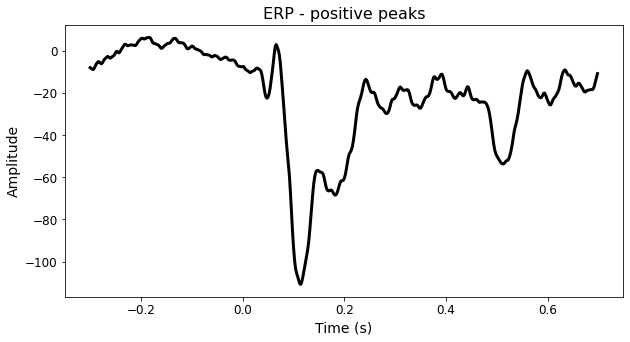

In [80]:
# finp positive ERP peaks
peaks_pos, properties_pos = find_peaks(erp_ga, height=thresh_height, distance = 10)
print(peaks_pos)

# plot ERP and identified peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.set(title='ERP - positive peaks', xlabel='Time (s)', ylabel='Amplitude')
ax.plot(time, erp_ga, color='k', linewidth=3)
for value in peaks_pos:
    ax.axvline(time[value], color='k', linestyle='--')

peak_posamp = erp_ga[peaks_pos]
print(peak_posamp)

[207 241 406]
[-110.8605686   -68.4286567   -53.67262533]


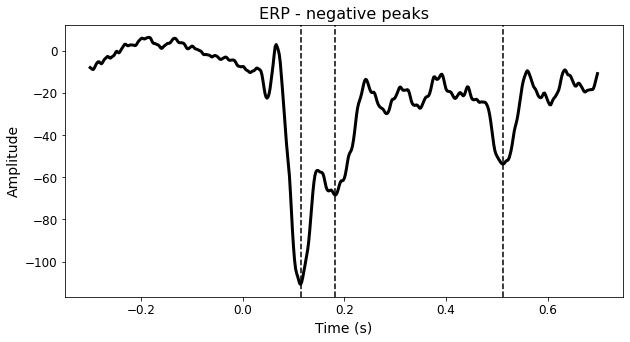

In [81]:
# find negative ERP peaks
peaks_neg, properties_neg = find_peaks(-erp_ga, height=thresh_height, distance = 10)
print(peaks_neg)

# plot ERP and identified peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, erp_ga, color='k', linewidth=3)
ax.set(title='ERP - negative peaks', xlabel='Time (s)', ylabel='Amplitude')
for value in peaks_neg:
    ax.axvline(time[value], color='k', linestyle='--')

peak_negamp = erp_ga[peaks_neg]
print(peak_negamp)

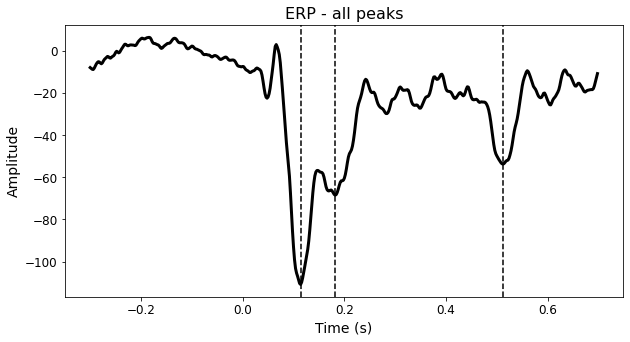

In [82]:
# plot all peaks
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, erp_ga, color='k', linewidth=3)
ax.set(title='ERP - all peaks', xlabel='Time (s)', ylabel='Amplitude')
for value in np.concatenate([peaks_pos, peaks_neg]):
    ax.axvline(time[value], color='k', linestyle='--')


### Quantify ERP 

In [ ]:
# # define function to define ERP params (latency, amplitude, width) for grand-average ERP
# NOTE: moved to utils

# def comp_erp_params(erp):
#     # init
#     params = pd.DataFrame()

#     # use scipy.find_peaks to find parameters
#     peaks_pos, _ = find_peaks(erp, height=height, distance = 10) 
#     peaks_neg, _ = find_peaks(-erp, height=height, distance = 10)

#     peaks = np.sort(np.concatenate([peaks_pos, peaks_neg]))
#     order = np.argsort(np.concatenate([peaks_pos, peaks_neg])) #use to sort widths
#     params['latency'] = peaks
    
#     # amplitude
#     params['amp'] = erp[peaks]

#     # find peaks width
#     widths_pos, _, _, _ = peak_widths(erp, peaks_pos)
#     widths_neg, _, _, _ = peak_widths(-erp, peaks_neg)
#     widths = np.concatenate([widths_pos, widths_neg])
#     params['widths'] = widths[order]

#     return params

    
# def crop_erp(erp, time, t_window):
#     mask = (time>=t_window[0]) & (time<=t_window[1])

#     return erp[mask], time[mask]

In [89]:
# trim ERP to stimulus presentation period
erp_crop, time_crop = trim_signal(erp_ga, time, [0, STIM_DURATOIN])
print(erp_ga.shape)
print(erp_crop.shape)

(500,)
(200,)


In [90]:
# compute ERP parameters
erp_params = comp_erp_params(erp_crop)
erp_params

,latency,amp,widths
0,7,-10.160297,7.618996
1,24,-22.355080,7.577591
2,33,3.123453,8.607770
3,57,-110.860569,24.326249
4,91,-68.428657,14.715253
5,127,-19.702553,0.822058
6,142,-29.666302,19.721595
7,158,-18.647709,3.319627
8,174,-27.100301,14.949958
9,191,-13.442593,3.218331


In [91]:
# convert latency to seconds
erp_params['peak_idx'] = erp_params['latency']
erp_params['latency'] = time_crop[erp_params['latency']]
erp_params

,latency,amp,widths,peak_idx
0,0.014,-10.160297,7.618996,7
1,0.048,-22.355080,7.577591,24
2,0.066,3.123453,8.607770,33
3,0.114,-110.860569,24.326249,57
4,0.182,-68.428657,14.715253,91
5,0.254,-19.702553,0.822058,127
6,0.284,-29.666302,19.721595,142
7,0.316,-18.647709,3.319627,158
8,0.348,-27.100301,14.949958,174
9,0.382,-13.442593,3.218331,191


### Parameterize ERPs for all sessions

In [100]:
# compute ERP and parameters for each data file

# loop through session
allsessions_list = []
for session in SESSIONS:
    print(f"\nAnalyzing session: {session}")
    
    # loop through arrays
    df_arraylist = []
    for ii in range(N_ARRAYS):
        print(f"    analyzing array: {ii}/{N_ARRAYS}")

        # get array and nsp index
        idx_array = ii + 1
        idx_nsp = (idx_array+1) // 2

        # load LFP and compute ERP
        fname_in = fr"{dir_input}\NSP{idx_nsp}_array{idx_array}_LFP.npy"
        lfp = np.load(fname_in)
        erp = compute_erp(lfp, time, t_baseline=T_BASELINE)

        # loop through channels
        for channel in range(erp.shape[0]):
            # trim ERP to stimulus presentation period
            erp_crop, time_crop = trim_signal(erp[channel], time, [0, STIM_DURATOIN])
            
            # compute ERP parameters
            df_array = comp_erp_params(erp_crop)

            # add session, channel and array
            df_array['session'] = session
            df_array['array'] = idx_array
            df_array['channel'] = channel
            
            # convert latency to seconds
            df_array['peak_idx'] = df_array['latency']
            df_array['latency'] = time_crop[df_array['latency']] 

            # append to list
            df_arraylist.append(df_array)
    
    # save dataframe per session
    df_session = pd.concat(df_arraylist)
    df_session.to_csv(fr'G:\Shared drives\v1_v4_1024\data\results\{session}_erp_params_df.csv')

    # save all sessions dataframe
    allsessions_list.append(df_session)

df_allsessions = pd.concat(allsessions_list)
df_allsessions.to_csv(fr'G:\Shared drives\v1_v4_1024\data\results\allsessions_erp_params_df.csv')        



Analyzing session: A_SNR_140819
    analyzing array: 0/16
    analyzing array: 1/16
    analyzing array: 2/16
    analyzing array: 3/16
    analyzing array: 4/16
    analyzing array: 5/16
    analyzing array: 6/16
    analyzing array: 7/16
    analyzing array: 8/16
    analyzing array: 9/16
    analyzing array: 10/16
    analyzing array: 11/16
    analyzing array: 12/16
    analyzing array: 13/16
    analyzing array: 14/16
    analyzing array: 15/16

Analyzing session: L_SNR_250717
    analyzing array: 0/16
    analyzing array: 1/16
    analyzing array: 2/16
    analyzing array: 3/16
    analyzing array: 4/16
    analyzing array: 5/16
    analyzing array: 6/16
    analyzing array: 7/16
    analyzing array: 8/16
    analyzing array: 9/16
    analyzing array: 10/16
    analyzing array: 11/16
    analyzing array: 12/16
    analyzing array: 13/16
    analyzing array: 14/16
    analyzing array: 15/16

Analyzing session: A_SNR_041018
    analyzing array: 0/16
    analyzing array: 1/16
    a

In [101]:
df_allsessions

,latency,amp,widths,session,array,channel,peak_idx
0,0.066,92.559219,10.326319,A_SNR_140819,1,0,33
1,0.144,91.460527,28.511070,A_SNR_140819,1,0,72
2,0.232,-41.283436,28.069168,A_SNR_140819,1,0,116
0,0.066,79.580379,9.914758,A_SNR_140819,1,1,33
1,0.142,107.467762,25.780069,A_SNR_140819,1,1,71
...,...,...,...,...,...,...,...
2,0.120,-151.010257,33.804268,A_SNR_041018,16,62,60
3,0.166,-68.138155,0.890100,A_SNR_041018,16,62,83
0,0.074,74.550596,13.864261,A_SNR_041018,16,63,37
1,0.120,-137.211409,28.506139,A_SNR_041018,16,63,60


In [102]:
# re-order columns
df_allsessions = df_allsessions[['session', 'array', 'channel', 'latency', 'amp', 'widths']]
df_allsessions

,session,array,channel,latency,amp,widths
0,A_SNR_140819,1,0,0.066,92.559219,10.326319
1,A_SNR_140819,1,0,0.144,91.460527,28.511070
2,A_SNR_140819,1,0,0.232,-41.283436,28.069168
0,A_SNR_140819,1,1,0.066,79.580379,9.914758
1,A_SNR_140819,1,1,0.142,107.467762,25.780069
...,...,...,...,...,...,...
2,A_SNR_041018,16,62,0.120,-151.010257,33.804268
3,A_SNR_041018,16,62,0.166,-68.138155,0.890100
0,A_SNR_041018,16,63,0.074,74.550596,13.864261
1,A_SNR_041018,16,63,0.120,-137.211409,28.506139


### Find highest-amplitude ERP peak for each channel

In [103]:
# take mean of absolute values
df_max = df_allsessions.groupby(by=['session', 'array', 'channel']).apply(np.max, axis = 0)
df_max = df_allsessions.groupby(by=['session','array','channel']).apply(lambda x: np.mean(np.abs(x)))
df_max.to_csv(fr'G:\Shared drives\v1_v4_1024\data\results\max_erp_params_df.csv')
